<a href="https://colab.research.google.com/github/othmanebenlamlih/PFE/blob/main/PFE_Breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation
Le carcinome canalaire invasif (CDI) est - avec ~ 80% des cas - l'un des types de cancer du sein les plus courants. Il est malveillant et capable de former des métastases, ce qui le rend particulièrement dangereux. Une biopsie est souvent effectuée pour prélever de petits échantillons de tissus. Ensuite, un pathologiste doit décider si une patiente est atteinte d'IDC, d'un autre type de cancer du sein ou est en bonne santé. En outre, les cellules malades doivent être localisées pour connaître l'état d'avancement de la maladie et le grade à attribuer. Cela doit être fait manuellement et prend du temps. De plus, la décision dépend de l'expertise du pathologiste et de son équipement. Par conséquent, le Deep Learning pourrait aider pour détecter et localiser automatiquement les cellules des tissus tumoraux et pour accélérer le processus. Afin d'exploiter tout le potentiel, on va construire un CNN en utilisant des quantités massives de données d'images de tissus qui ont été évaluées par différents experts. 

# Setup

Les ensembles de données disponibles sur la plateforme Kaggle peuvent être importés directement dans Google Colab. 
Pour accéder à l'API Kaggle on doit exécuter les commandes suivantes. Celles-ci sont décrites dans ce tutoriel: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benlamlihothmane","key":"ebc68494200b00eb5534850edcf3ab77"}'}

In [ ]:
 ! mkdir -p ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:53<00:00, 45.4MB/s]
100% 3.10G/3.10G [00:53<00:00, 62.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "breast-histopathology-images.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall('DataFolder')
  print('Done')

Done


In [ ]:
import numpy as np 
import pandas as pd 
import os
import cv2
from matplotlib import pyplot as plt
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
import itertools
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import regularizers

# 1. Chargement des données:

Nous utiliserons l'ensemble de données IDC_regular (the breast cancer histology image dataset) de Kaggle. Cette base de données contient 277 524 patchs de taille 50 × 50 extraits de 162 images de diapositives de montage entières d'échantillons de cancer du sein numérisés à 40x. Parmi ceux-ci, 1 98 738 tests négatifs et 78 786 tests positifs avec IDC.

In [ ]:
from glob import glob
data = glob('/content/DataFolder/**/*.png', recursive=True)

Ici, nous affichons les vingt premiers patchs d'images:

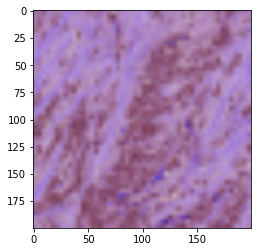

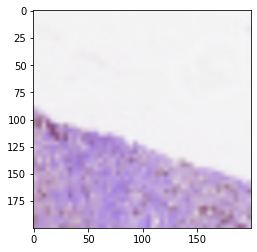

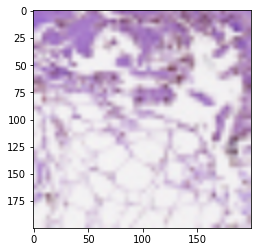

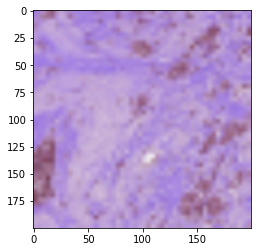

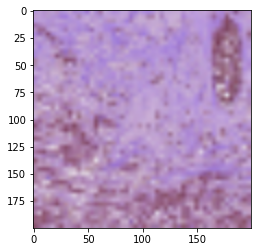

In [ ]:
for i in data[:5]:
    img=cv2.imread(i)
    img_1=cv2.resize(img,(200,200))
    plt.imshow(img_1,cmap='binary')
    plt.show()

# 2. Traitement des données

Un échantillon de données est stocké dans une liste d'images avec leurs étiquettes.

In [ ]:
images=[]
labels=[]
for i in data[:5000]:
    if i.endswith('.png'):
        label=i[-5]
        img=cv2.imread(i)
        img_1=cv2.resize(img,(100,100))
        images.append(img_1)
        labels.append(label)

### Normalisation
La normalisation vise à ajuster les valeurs des données à une échelle entre 0 et 1.
On peut noter plusieurs bénéfices dus à la normalisation, comme :
- Réseau de neurones non biaisé
-ça impact aussi l'optimisation,  elle sera plus rapide vu que les weights seront réduit à un certain intervalle ( explosion des weights évitée)

In [ ]:
x=np.stack(images)       
y=to_categorical(labels)
x=x/255


### Division des données

Nous divisons nos données en ensembles d'apprentissage (75%) et de test (25%).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3750, 100, 100, 3)
(1250, 100, 100, 3)
(3750, 2)
(1250, 2)


# 3. Construction du modèle CNN

Pour créer notre modèle de réseau de neurones, on va implémenter la fonction forward_propagation ci-dessous:   CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

La BatchNormalisation est utilisée pour rendre le réseau de neurones plus rapide et plus stable. Aussi, un Dropout pour éviter le Overfitting du modèle. 

In [ ]:
model=Sequential([
    Conv2D(64,(3,3),activation='relu',input_shape=(100,100,3), kernel_regularizer=regularizers.l2(0.2)),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(128,(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(0.2)),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(256,(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(0.2)),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(512,(3,3),activation='relu',padding='same', kernel_regularizer=regularizers.l2(0.2)),
    MaxPool2D((2,2)),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(1024,activation='relu', kernel_regularizer=regularizers.l2(0.2)),
    Dense(2,activation='sigmoid', kernel_regularizer=regularizers.l2(0.2))
])

# 4. Transfer learning

### Chargement du modèle VGG16

In [ ]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100,100, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Nous empêchons la mise à jour des poids du modèle VGG16 pendant l'entraînement, à l'exception des quatre dernières couches.

In [ ]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7faa92e86c90> False
<keras.layers.convolutional.Conv2D object at 0x7faa703874d0> False
<keras.layers.convolutional.Conv2D object at 0x7faa82eb55d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7faa70382bd0> False
<keras.layers.convolutional.Conv2D object at 0x7faa703d1e50> False
<keras.layers.convolutional.Conv2D object at 0x7faa7030cb10> False
<keras.layers.pooling.MaxPooling2D object at 0x7faa70311d50> False
<keras.layers.convolutional.Conv2D object at 0x7faa70316510> False
<keras.layers.convolutional.Conv2D object at 0x7faa7031eb50> False
<keras.layers.convolutional.Conv2D object at 0x7faa70311fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7faa703296d0> False
<keras.layers.convolutional.Conv2D object at 0x7faa7032ed50> False
<keras.layers.convolutional.Conv2D object at 0x7faa70333c90> False
<keras.layers.convolutional.Conv2D object at 0x7faa70326bd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7faa7033bfd0>

In [ ]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.2)))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 19,436,354
Trainable params: 11,801,090
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
model.compile(optimizer = RMSprop(lr=1e-4) , loss = "binary_crossentropy", metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(x_train, y_train, batch_size=16,epochs=10
                            ,verbose=1,validation_data=(x_test, y_test))

Epoch 1/10
235/235 [==============================] - 55s 42ms/step - loss: 194.2713 - accuracy: 0.8070 - val_loss: 9.9964 - val_accuracy: 0.8392
Epoch 2/10
235/235 [==============================] - 8s 35ms/step - loss: 3.8726 - accuracy: 0.8671 - val_loss: 0.5514 - val_accuracy: 0.8488
Epoch 3/10
235/235 [==============================] - 8s 35ms/step - loss: 0.4253 - accuracy: 0.8935 - val_loss: 0.3999 - val_accuracy: 0.8688
Epoch 4/10
235/235 [==============================] - 8s 35ms/step - loss: 0.3130 - accuracy: 0.9083 - val_loss: 0.3976 - val_accuracy: 0.8688
Epoch 5/10
235/235 [==============================] - 8s 35ms/step - loss: 0.2641 - accuracy: 0.9192 - val_loss: 0.3984 - val_accuracy: 0.8656
Epoch 6/10
235/235 [==============================] - 8s 36ms/step - loss: 0.2091 - accuracy: 0.9312 - val_loss: 0.6516 - val_accuracy: 0.7816
Epoch 7/10
235/235 [==============================] - 8s 36ms/step - loss: 0.1971 - accuracy: 0.9393 - val_loss: 0.4642 - val_accuracy: 0.8

# 5. Evaluation du modèle

In [ ]:
test_eval = model.evaluate(x_test,y_test,verbose = 1)

40/40 [==============================] - 3s 32ms/step - loss: 1.0148 - accuracy: 0.8240


Test loss: 1.0147523880004883
Test accuracy: 0.8240000009536743


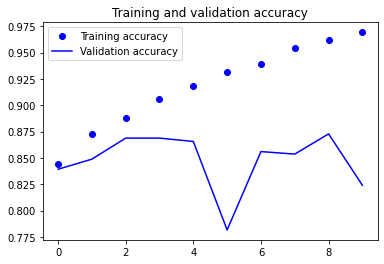

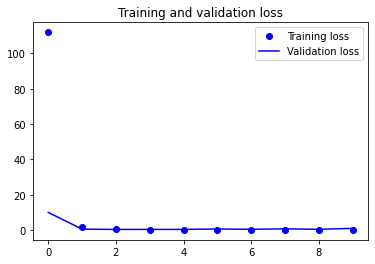

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:

# Save Model and Weights
model.save('bvgg16.h5')
model.save_weights('bvgg16.hdf5')

In [ ]:
# Load saved model
from keras.models import load_model
model_vgg16 = load_model('bvgg16.h5')

In [ ]:
y_pred = model_vgg16.predict(x_test, batch_size=1)

In [ ]:
y_pred[1]

array([1.0000000e+00, 5.4632422e-14], dtype=float32)

In [ ]:
y_pred[0]

array([1.000000e+00, 5.984379e-14], dtype=float32)

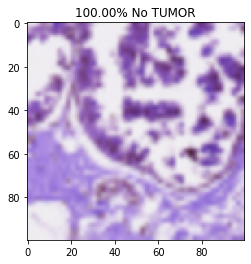

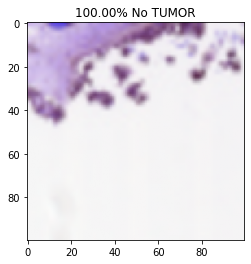

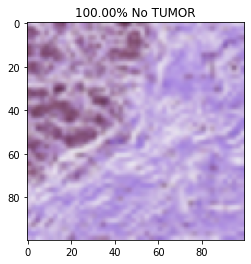

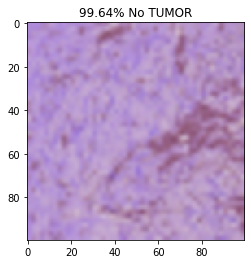

In [ ]:
prediction=y_pred[0:4]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% TUMOR')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% No TUMOR')
  plt.imshow(x_test[index])
  plt.show()

# Conclusion

Dans ce projet, nous avons construit un réseau de neurones à partir du modèle VGG16 préentrainé sur la base de données ImageNet. L'utilisation du Transfer Learning lors de l'apprentissage a grandement réduit le temps du calcul et a permis la classification des images des tumeurs avec une précision de 87%. 